## **PART 1: Learning about Particle Swarm Optimization (PSO)**

### *What is PSO and how does it solve optimization problems?*

* Particle Swarm Optimization operates as a nature-inspired optimization algorithm, drawing inspiration from the social behaviors observed in birds and fish. The fundamental concept of PSO involves simulating the interactions among a group of entities, termed particles, as they traverse a search space in pursuit of optimal solutions. PSO excels in addressing optimization problems by emulating the social dynamics among particles. This is achieved through the continual adjustment of particle velocities and positions, influenced by both individual and collective best-known positions. The algorithm adeptly balances exploration and exploitation, enabling particles to explore broadly while gradually converging towards promising regions within the search space. The collaborative knowledge-sharing within the particle swarm enhances the overall efficiency of the optimization process. Notably, the iterative nature and adaptability of PSO contribute significantly to its efficacy in navigating intricate and dynamic optimization landscapes, rendering it a versatile and broadly applicable algorithm across diverse domains.

## **PART 2: Moving Peaks Benchmark using Multiswarm PSO**

## *1. Benchmark Runs for all 3 Scenarios*

### *Initializations*

In [18]:
import itertools
import math
import operator
import random
import matplotlib.pyplot as plt

import numpy

try:
    from itertools import imap
except:
    # Python 3 nothing to do
    pass
else:
    map = imap

from deap import base
from deap.benchmarks import movingpeaks
from deap import creator
from deap import tools

In [19]:
scenario = movingpeaks.SCENARIO_1

NDIM = 5
BOUNDS = [scenario["min_coord"], scenario["max_coord"]]

mpb = movingpeaks.MovingPeaks(dim=NDIM, **scenario)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, 
    best=None, bestfit=creator.FitnessMax)
creator.create("Swarm", list, best=None, bestfit=creator.FitnessMax)

def generate(pclass, dim, pmin, pmax, smin, smax):
    part = pclass(random.uniform(pmin, pmax) for _ in range(dim)) 
    part.speed = [random.uniform(smin, smax) for _ in range(dim)]
    return part

def convertQuantum(swarm, rcloud, centre, dist):
    dim = len(swarm[0])
    for part in swarm:
        position = [random.gauss(0, 1) for _ in range(dim)]
        dist = math.sqrt(sum(x**2 for x in position))

        if dist == "gaussian":
            u = abs(random.gauss(0, 1.0/3.0))
            part[:] = [(rcloud * x * u**(1.0/dim) / dist) + c for x, c in zip(position, centre)]

        elif dist == "uvd":
            u = random.random()
            part[:] = [(rcloud * x * u**(1.0/dim) / dist) + c for x, c in zip(position, centre)]

        elif dist == "nuvd":
            u = abs(random.gauss(0, 1.0/3.0))
            part[:] = [(rcloud * x * u / dist) + c for x, c in zip(position, centre)]

        del part.fitness.values
        del part.bestfit.values
        part.best = None

    return swarm

def updateParticle(part, best, chi, c):
    ce1 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce2 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce1_p = map(operator.mul, ce1, map(operator.sub, best, part))
    ce2_g = map(operator.mul, ce2, map(operator.sub, part.best, part))
    a = map(operator.sub,
                      map(operator.mul,
                                    itertools.repeat(chi),
                                    map(operator.add, ce1_p, ce2_g)),
                      map(operator.mul,
                                     itertools.repeat(1 - chi),
                                     part.speed))
    part.speed = list(map(operator.add, part.speed, a))
    part[:] = list(map(operator.add, part, part.speed))

toolbox = base.Toolbox()
toolbox.register("particle", generate, creator.Particle, dim=NDIM,
    pmin=BOUNDS[0], pmax=BOUNDS[1], smin=-(BOUNDS[1] - BOUNDS[0])/2.0,
    smax=(BOUNDS[1] - BOUNDS[0])/2.0)
toolbox.register("swarm", tools.initRepeat, creator.Swarm, toolbox.particle)
toolbox.register("update", updateParticle, chi=0.729843788, c=2.05)
toolbox.register("convert", convertQuantum, dist="nuvd")
toolbox.register("evaluate", mpb)

c:\Users\Marcus\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Marcus\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Marcus\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Swarm' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### **SCENARIO 1:**

In [20]:
def scenario1(verbose=True):
    NSWARMS = 1
    NPARTICLES = 5
    NEXCESS = 3
    RCLOUD = 0.5    # 0.5 times the move severity

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = "gen", "nswarm", "evals", "error", "offline_error", "avg", "max"

    # Generate the initial population
    population = [toolbox.swarm(n=NPARTICLES) for _ in range(NSWARMS)]

    # Evaluate each particle
    for swarm in population:
        for part in swarm:
            part.fitness.values = toolbox.evaluate(part)

            # Update swarm's attractors personal best and global best
            if not part.best or part.fitness > part.bestfit:
                part.best = toolbox.clone(part[:])          # Get the position
                part.bestfit.values = part.fitness.values   # Get the fitness
            if not swarm.best or part.fitness > swarm.bestfit:
                swarm.best = toolbox.clone(part[:])         # Get the position
                swarm.bestfit.values = part.fitness.values  # Get the fitness

    record = stats.compile(itertools.chain(*population))
    logbook.record(gen=0, evals=mpb.nevals, nswarm=len(population),
                   error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

    if verbose:
        print(logbook.stream)

    generation = 1
    globalMaxPerGen = [] # Global Maximum per generation
    while mpb.nevals < 5e5:
        
        #Add global maximum to list for plotting
        globalMaxPerGen.append(mpb.globalMaximum()[0])
        
        # Check for convergence
        rexcl = (BOUNDS[1] - BOUNDS[0]) / (2 * len(population)**(1.0/NDIM))

        not_converged = 0
        worst_swarm_idx = None
        worst_swarm = None
        for i, swarm in enumerate(population):
            # Compute the diameter of the swarm
            for p1, p2 in itertools.combinations(swarm, 2):
                d = math.sqrt(sum((x1 - x2)**2. for x1, x2 in zip(p1, p2)))
                if d > 2*rexcl:
                    not_converged += 1
                    # Search for the worst swarm according to its global best
                    if not worst_swarm or swarm.bestfit < worst_swarm.bestfit:
                        worst_swarm_idx = i
                        worst_swarm = swarm
                    break

        # If all swarms have converged, add a swarm
        if not_converged == 0:
            population.append(toolbox.swarm(n=NPARTICLES))
        # If too many swarms are roaming, remove the worst swarm
        elif not_converged > NEXCESS:
            population.pop(worst_swarm_idx)

        # Update and evaluate the swarm
        for swarm in population:
            # Check for change
            if swarm.best and toolbox.evaluate(swarm.best) != swarm.bestfit.values:
                # Convert particles to quantum particles
                swarm[:] = toolbox.convert(swarm, rcloud=RCLOUD, centre=swarm.best)
                swarm.best = None
                del swarm.bestfit.values

            for part in swarm:
                # Not necessary to update if it is a new swarm
                # or a swarm just converted to quantum
                if swarm.best and part.best:
                    toolbox.update(part, swarm.best)
                part.fitness.values = toolbox.evaluate(part)

                # Update swarm's attractors personal best and global best
                if not part.best or part.fitness > part.bestfit:
                    part.best = toolbox.clone(part[:])
                    part.bestfit.values = part.fitness.values
                if not swarm.best or part.fitness > swarm.bestfit:
                    swarm.best = toolbox.clone(part[:])
                    swarm.bestfit.values = part.fitness.values

        record = stats.compile(itertools.chain(*population))
        logbook.record(gen=generation, evals=mpb.nevals, nswarm=len(population),
                       error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

        if verbose:
            print(logbook.stream)

        # Apply exclusion
        reinit_swarms = set()
        for s1, s2 in itertools.combinations(range(len(population)), 2):
            # Swarms must have a best and not already be set to reinitialize
            if population[s1].best and population[s2].best and not (s1 in reinit_swarms or s2 in reinit_swarms):
                dist = 0
                for x1, x2 in zip(population[s1].best, population[s2].best):
                    dist += (x1 - x2)**2.
                dist = math.sqrt(dist)
                if dist < rexcl:
                    if population[s1].bestfit <= population[s2].bestfit:
                        reinit_swarms.add(s1)
                    else:
                        reinit_swarms.add(s2)

        # Reinitialize and evaluate swarms
        for s in reinit_swarms:
            population[s] = toolbox.swarm(n=NPARTICLES)
            for part in population[s]:
                part.fitness.values = toolbox.evaluate(part)

                # Update swarm's attractors personal best and global best
                if not part.best or part.fitness > part.bestfit:
                    part.best = toolbox.clone(part[:])
                    part.bestfit.values = part.fitness.values
                if not population[s].best or part.fitness > population[s].bestfit:
                    population[s].best = toolbox.clone(part[:])
                    population[s].bestfit.values = part.fitness.values
        generation += 1
    
    bestSols = logbook.select("max") # list of best solutions found by MPSO per generation

    plt.plot(globalMaxPerGen, label = "Global Maximum")
    plt.plot(bestSols, label = "Best Solution Found ")
    plt.title("Value per Generation")
    plt.xlabel("Generation")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

### *SCENARIO 1 Results:*

gen	nswarm	evals	error 	offline_error	avg     	max     
0  	1     	5    	49.203	49.203       	0.247135	0.797014
1  	2     	16   	49.203	49.203       	0.119276	0.211998
2  	2     	28   	49.203	49.203       	0.218129	0.498791
3  	2     	40   	49.203	49.203       	0.191317	0.579325
4  	2     	52   	49.203	49.203       	0.245912	0.625954
5  	3     	69   	48.9957	49.1639      	0.289603	1.00434 
6  	3     	87   	48.992 	49.1287      	0.344757	1.00803 
7  	3     	110  	48.7905	49.0745      	0.339851	1.20951 
8  	3     	128  	48.248 	49.0155      	0.505108	1.752   
9  	3     	151  	48.248 	48.8986      	0.308305	0.764115
10 	3     	174  	48.248 	48.8126      	0.3508  	1.01623 
11 	3     	192  	47.7216	48.7407      	0.623844	2.27841 
12 	3     	210  	47.7216	48.6534      	0.61448 	2.17747 
13 	3     	228  	47.3744	48.5692      	0.753669	2.6256  
14 	3     	246  	47.3744	48.4817      	1.12628 	2.52591 
15 	3     	264  	46.4415	48.378       	1.0303  	3.55849 
16 	3     	282  	46.4415	48.2544     

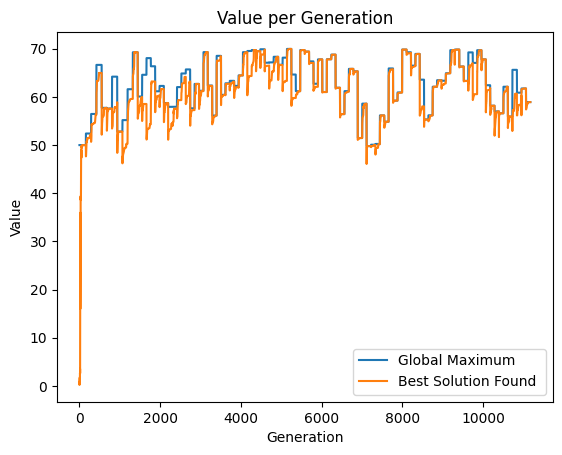

In [21]:
scenario1()

### **SCENARIO 2:**

In [31]:
scenario = movingpeaks.SCENARIO_2
BOUNDS = [scenario["min_coord"], scenario["max_coord"]]
mpb = movingpeaks.MovingPeaks(dim=NDIM, **scenario)
toolbox.register("evaluate", mpb)

In [32]:
def scenario2(verbose=True):
    NSWARMS = 1
    NPARTICLES = 5
    NEXCESS = 3
    RCLOUD = 0.5    # 0.5 times the move severity

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = "gen", "nswarm", "evals", "error", "offline_error", "avg", "max"

    # Generate the initial population
    population = [toolbox.swarm(n=NPARTICLES) for _ in range(NSWARMS)]

    # Evaluate each particle
    for swarm in population:
        for part in swarm:
            part.fitness.values = toolbox.evaluate(part)

            # Update swarm's attractors personal best and global best
            if not part.best or part.fitness > part.bestfit:
                part.best = toolbox.clone(part[:])          # Get the position
                part.bestfit.values = part.fitness.values   # Get the fitness
            if not swarm.best or part.fitness > swarm.bestfit:
                swarm.best = toolbox.clone(part[:])         # Get the position
                swarm.bestfit.values = part.fitness.values  # Get the fitness

    record = stats.compile(itertools.chain(*population))
    logbook.record(gen=0, evals=mpb.nevals, nswarm=len(population),
                   error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

    if verbose:
        print(logbook.stream)

    generation = 1
    globalMaxPerGen = [] # Global Maximum per generation
    while mpb.nevals < 5e5:
        
        #Add global maximum to list for plotting
        globalMaxPerGen.append(mpb.globalMaximum()[0])
        
        # Check for convergence
        rexcl = (BOUNDS[1] - BOUNDS[0]) / (2 * len(population)**(1.0/NDIM))

        not_converged = 0
        worst_swarm_idx = None
        worst_swarm = None
        for i, swarm in enumerate(population):
            # Compute the diameter of the swarm
            for p1, p2 in itertools.combinations(swarm, 2):
                d = math.sqrt(sum((x1 - x2)**2. for x1, x2 in zip(p1, p2)))
                if d > 2*rexcl:
                    not_converged += 1
                    # Search for the worst swarm according to its global best
                    if not worst_swarm or swarm.bestfit < worst_swarm.bestfit:
                        worst_swarm_idx = i
                        worst_swarm = swarm
                    break

        # If all swarms have converged, add a swarm
        if not_converged == 0:
            population.append(toolbox.swarm(n=NPARTICLES))
        # If too many swarms are roaming, remove the worst swarm
        elif not_converged > NEXCESS:
            population.pop(worst_swarm_idx)

        # Update and evaluate the swarm
        for swarm in population:
            # Check for change
            if swarm.best and toolbox.evaluate(swarm.best) != swarm.bestfit.values:
                # Convert particles to quantum particles
                swarm[:] = toolbox.convert(swarm, rcloud=RCLOUD, centre=swarm.best)
                swarm.best = None
                del swarm.bestfit.values

            for part in swarm:
                # Not necessary to update if it is a new swarm
                # or a swarm just converted to quantum
                if swarm.best and part.best:
                    toolbox.update(part, swarm.best)
                part.fitness.values = toolbox.evaluate(part)

                # Update swarm's attractors personal best and global best
                if not part.best or part.fitness > part.bestfit:
                    part.best = toolbox.clone(part[:])
                    part.bestfit.values = part.fitness.values
                if not swarm.best or part.fitness > swarm.bestfit:
                    swarm.best = toolbox.clone(part[:])
                    swarm.bestfit.values = part.fitness.values

        record = stats.compile(itertools.chain(*population))
        logbook.record(gen=generation, evals=mpb.nevals, nswarm=len(population),
                       error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

        if verbose:
            print(logbook.stream)

        # Apply exclusion
        reinit_swarms = set()
        for s1, s2 in itertools.combinations(range(len(population)), 2):
            # Swarms must have a best and not already be set to reinitialize
            if population[s1].best and population[s2].best and not (s1 in reinit_swarms or s2 in reinit_swarms):
                dist = 0
                for x1, x2 in zip(population[s1].best, population[s2].best):
                    dist += (x1 - x2)**2.
                dist = math.sqrt(dist)
                if dist < rexcl:
                    if population[s1].bestfit <= population[s2].bestfit:
                        reinit_swarms.add(s1)
                    else:
                        reinit_swarms.add(s2)

        # Reinitialize and evaluate swarms
        for s in reinit_swarms:
            population[s] = toolbox.swarm(n=NPARTICLES)
            for part in population[s]:
                part.fitness.values = toolbox.evaluate(part)

                # Update swarm's attractors personal best and global best
                if not part.best or part.fitness > part.bestfit:
                    part.best = toolbox.clone(part[:])
                    part.bestfit.values = part.fitness.values
                if not population[s].best or part.fitness > population[s].bestfit:
                    population[s].best = toolbox.clone(part[:])
                    population[s].bestfit.values = part.fitness.values
        generation += 1
    
    bestSols = logbook.select("max") # list of best solutions found by MPSO per generation

    plt.plot(globalMaxPerGen, label = "Global Maximum")
    plt.plot(bestSols, label = "Best Solution Found ")
    plt.title("Value per Generation")
    plt.xlabel("Generation")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

### *SCENARIO 2 Results:*

gen	nswarm	evals	error  	offline_error	avg    	max     
0  	1     	5    	62.4105	72.3914      	-50.651	-12.4105
1  	2     	16   	61.5509	65.1535      	-65.9748	-11.5509
2  	2     	28   	61.5509	63.6095      	-86.729 	-35.5121
3  	2     	40   	57.3757	62.1569      	-75.5132	-7.37573
4  	2     	52   	57.3757	61.0536      	-97.7978	-35.6346
5  	2     	64   	51.2454	60.0766      	-58.9762	-1.24537
6  	2     	76   	51.2454	58.6822      	-98.4181	-8.86857
7  	2     	88   	51.2454	57.6681      	-59.5387	-1.82703
8  	2     	100  	37.0746	55.4803      	-62.3285	12.9254 
9  	2     	112  	37.0746	53.5082      	-73.6099	-34.4236
10 	2     	124  	37.0746	51.9179      	-59.8137	-1.88132
11 	2     	136  	35.2257	50.4722      	-70.0014	14.7743 
12 	2     	148  	35.2257	49.236       	-45.3152	6.26619 
13 	2     	160  	35.2257	48.1853      	-47.5048	7.1498  
14 	2     	172  	35.2257	47.2811      	-24.1025	13.957  
15 	3     	189  	26.9789	45.8751      	-53.1213	23.0211 
16 	3     	207  	14.8737	43.4132 

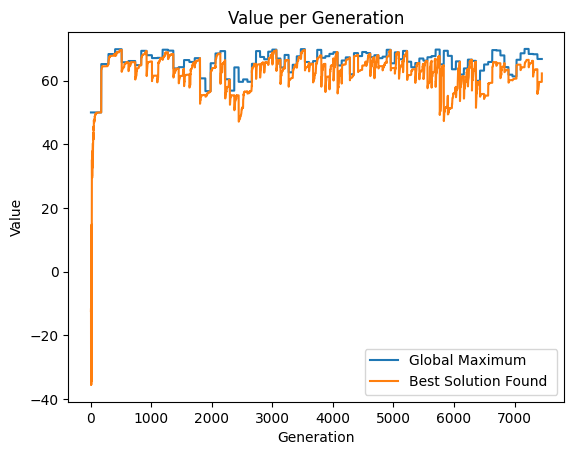

In [33]:
scenario2()

### **SCENARIO 3:**

In [34]:
scenario = movingpeaks.SCENARIO_3
BOUNDS = [scenario["min_coord"], scenario["max_coord"]]
mpb = movingpeaks.MovingPeaks(dim=NDIM, **scenario)
toolbox.register("evaluate", mpb)

In [35]:
def scenario3(verbose=True):
    NSWARMS = 1
    NPARTICLES = 5
    NEXCESS = 3
    RCLOUD = 0.5    # 0.5 times the move severity

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = "gen", "nswarm", "evals", "error", "offline_error", "avg", "max"

    # Generate the initial population
    population = [toolbox.swarm(n=NPARTICLES) for _ in range(NSWARMS)]

    # Evaluate each particle
    for swarm in population:
        for part in swarm:
            part.fitness.values = toolbox.evaluate(part)

            # Update swarm's attractors personal best and global best
            if not part.best or part.fitness > part.bestfit:
                part.best = toolbox.clone(part[:])          # Get the position
                part.bestfit.values = part.fitness.values   # Get the fitness
            if not swarm.best or part.fitness > swarm.bestfit:
                swarm.best = toolbox.clone(part[:])         # Get the position
                swarm.bestfit.values = part.fitness.values  # Get the fitness

    record = stats.compile(itertools.chain(*population))
    logbook.record(gen=0, evals=mpb.nevals, nswarm=len(population),
                   error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

    if verbose:
        print(logbook.stream)

    generation = 1
    globalMaxPerGen = [] # Global Maximum per generation
    while mpb.nevals < 5e5:
        
        #Add global maximum to list for plotting
        globalMaxPerGen.append(mpb.globalMaximum()[0])
        
        # Check for convergence
        rexcl = (BOUNDS[1] - BOUNDS[0]) / (2 * len(population)**(1.0/NDIM))

        not_converged = 0
        worst_swarm_idx = None
        worst_swarm = None
        for i, swarm in enumerate(population):
            # Compute the diameter of the swarm
            for p1, p2 in itertools.combinations(swarm, 2):
                d = math.sqrt(sum((x1 - x2)**2. for x1, x2 in zip(p1, p2)))
                if d > 2*rexcl:
                    not_converged += 1
                    # Search for the worst swarm according to its global best
                    if not worst_swarm or swarm.bestfit < worst_swarm.bestfit:
                        worst_swarm_idx = i
                        worst_swarm = swarm
                    break

        # If all swarms have converged, add a swarm
        if not_converged == 0:
            population.append(toolbox.swarm(n=NPARTICLES))
        # If too many swarms are roaming, remove the worst swarm
        elif not_converged > NEXCESS:
            population.pop(worst_swarm_idx)

        # Update and evaluate the swarm
        for swarm in population:
            # Check for change
            if swarm.best and toolbox.evaluate(swarm.best) != swarm.bestfit.values:
                # Convert particles to quantum particles
                swarm[:] = toolbox.convert(swarm, rcloud=RCLOUD, centre=swarm.best)
                swarm.best = None
                del swarm.bestfit.values

            for part in swarm:
                # Not necessary to update if it is a new swarm
                # or a swarm just converted to quantum
                if swarm.best and part.best:
                    toolbox.update(part, swarm.best)
                part.fitness.values = toolbox.evaluate(part)

                # Update swarm's attractors personal best and global best
                if not part.best or part.fitness > part.bestfit:
                    part.best = toolbox.clone(part[:])
                    part.bestfit.values = part.fitness.values
                if not swarm.best or part.fitness > swarm.bestfit:
                    swarm.best = toolbox.clone(part[:])
                    swarm.bestfit.values = part.fitness.values

        record = stats.compile(itertools.chain(*population))
        logbook.record(gen=generation, evals=mpb.nevals, nswarm=len(population),
                       error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

        if verbose:
            print(logbook.stream)

        # Apply exclusion
        reinit_swarms = set()
        for s1, s2 in itertools.combinations(range(len(population)), 2):
            # Swarms must have a best and not already be set to reinitialize
            if population[s1].best and population[s2].best and not (s1 in reinit_swarms or s2 in reinit_swarms):
                dist = 0
                for x1, x2 in zip(population[s1].best, population[s2].best):
                    dist += (x1 - x2)**2.
                dist = math.sqrt(dist)
                if dist < rexcl:
                    if population[s1].bestfit <= population[s2].bestfit:
                        reinit_swarms.add(s1)
                    else:
                        reinit_swarms.add(s2)

        # Reinitialize and evaluate swarms
        for s in reinit_swarms:
            population[s] = toolbox.swarm(n=NPARTICLES)
            for part in population[s]:
                part.fitness.values = toolbox.evaluate(part)

                # Update swarm's attractors personal best and global best
                if not part.best or part.fitness > part.bestfit:
                    part.best = toolbox.clone(part[:])
                    part.bestfit.values = part.fitness.values
                if not population[s].best or part.fitness > population[s].bestfit:
                    population[s].best = toolbox.clone(part[:])
                    population[s].bestfit.values = part.fitness.values
        generation += 1
    
    bestSols = logbook.select("max") # list of best solutions found by MPSO per generation

    plt.plot(globalMaxPerGen, label = "Global Maximum")
    plt.plot(bestSols, label = "Best Solution Found ")
    plt.title("Value per Generation")
    plt.xlabel("Generation")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

### *SCENARIO 3 Results:*

gen	nswarm	evals	error  	offline_error	avg	max
0  	1     	5    	59.6221	59.6221      	10 	10 
1  	2     	16   	56.5272	59.4287      	10.3095	13.0949
2  	2     	28   	51.1903	57.6134      	10.9142	18.4318
3  	2     	40   	36.7503	55.3255      	12.8981	32.8718
4  	2     	52   	36.7503	51.0389      	11.222 	22.2203
5  	2     	64   	36.7503	48.3598      	10.6863	16.863 
6  	2     	76   	36.7503	46.5267      	12.0491	30.4913
7  	2     	88   	33.6655	45.1585      	16.2033	35.9566
8  	2     	100  	28.654 	43.629       	13.2306	40.9681
9  	2     	112  	28.654 	42.0245      	16.3877	39.4532
10 	2     	124  	28.654 	40.7306      	13.8727	30.253 
11 	3     	141  	27.9395	39.2362      	15.9736	41.6826
12 	3     	159  	27.9395	37.9574      	14.8343	38.9566
13 	3     	177  	27.9395	36.9386      	16.6032	39.5125
14 	3     	195  	27.9395	36.1079      	17.0625	40.0509
15 	3     	213  	21.9913	35.1104      	19.8911	47.6308
16 	3     	231  	17.7056	33.8841      	22.0164	51.9165
17 	3     	249  	17.7056	3

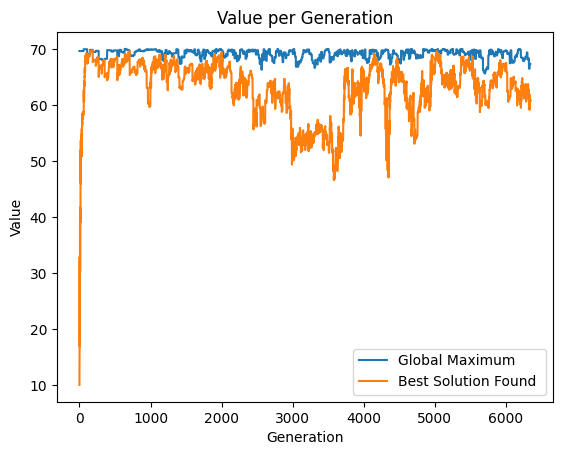

In [36]:
scenario3()

## *2. MPSO Analysis*

Out of all the scenarios, MPSO performed best in SCENARIO 1, having the lowest offline error and fastest runtime. One notable thing about SCENARIO 1 is that its low number of evalutations per generation resulted in it having the most number of generations. This might be due to SCENARIO 1 having the least amount of peaks.

For SCENARIO 2 it MPSO performed worse, having a higher offline error and higher runtime. This can be attributed to SCENARIO 2 having more peaks than SCENARIO 1 and also having a higher standard deviation of change and move severity for each peak change.

For SCENARIO 3, MPSO performed the worst. It has an all around higher offline error and triple the average runtime of SCENARIO 1 and 2. This can be attributed to SCENARIO 3 having 5 times the amount of peak compared to SCENARIO 2 even if it has a lower standard deviation of change and move severity.

From the results, we can observe that the number of peaks has the biggest effect on performance compared to rate of change.

In conclusion, the performance of the MPSO algorithm across different scenarios reveals that it excels in situations with a lower number of peaks, as demonstrated in SCENARIO 1. The number of peaks emerges as a critical factor influencing algorithm performance, outweighing the impact of the rate of change. These findings highlight the importance of considering the complexity of the optimization landscape when selecting or designing algorithms for specific scenarios.